In [1]:
%matplotlib inline
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot
import mapclassify

In [9]:
plt.rcParams['figure.figsize'] = (70, 20)

In [2]:
df_municipalities = gpd.read_file('shape/municipalities_2018.geojson')

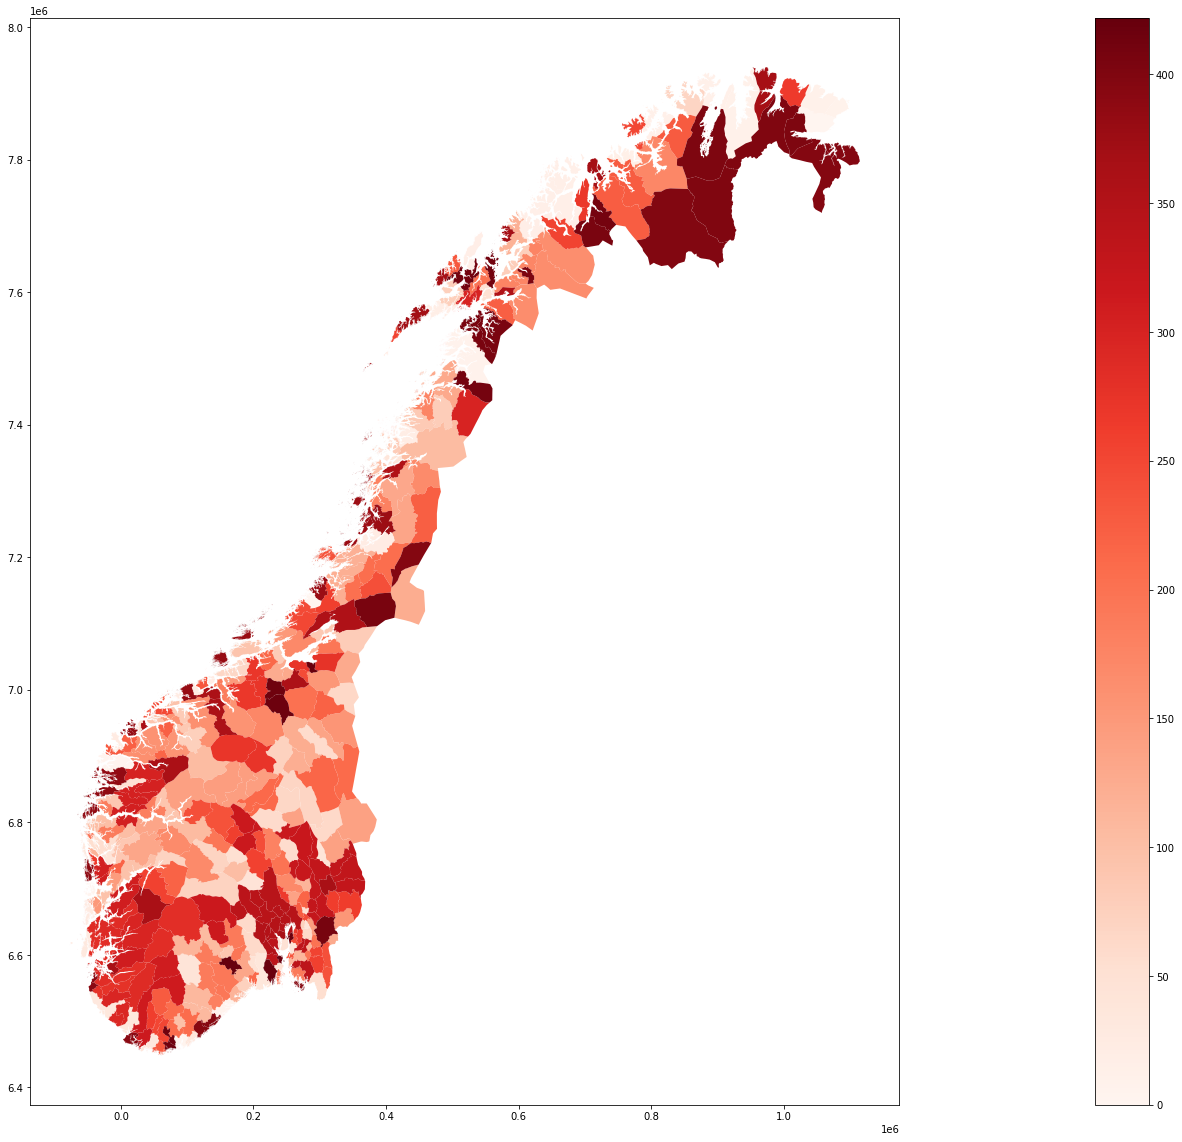

In [5]:
ax = df_municipalities.plot(
    column=np.array([i for i in range(len(df_municipalities))]), 
    cmap='Reds', 
    legend=True, 
    vmin=0.0,
    vmax=float(len(df_municipalities))
)

In [8]:
print(list(df_municipalities.iloc[:,1])) # Municipalities!

['Vadsø', 'Osen', 'Bremanger', 'Austevoll', 'Kristiansand', 'Tvedestrand', 'Risør', 'Steigen', 'Sørfold', 'Vardø', 'Båtsfjord', 'Lebesby', 'Nordkapp', 'Hammerfest', 'Loppa', 'Karlsøy', 'Tromsø', 'Lenvik', 'Andøy', 'Vågan', 'Værøy', 'Rødøy', 'Bindal', 'Kristiansund', 'Eide', 'Aukra', 'Selje', 'Fedje', 'Bømlo', 'Haugesund', 'Karmøy', 'Utsira', 'Hå', 'Eigersund', 'Flekkefjord', 'Lindesnes', 'Lillesand', 'Larvik', 'Nesna', 'Øygarden', 'Osterøy', 'Rælingen', 'Løten', 'Fyresdal', 'Vestby', 'Flå', 'Svelvik', 'Siljan', 'Tønsberg', 'Hurum', 'Naustdal', 'Ulstein', 'Tjeldsund', 'Gol', 'Gjerdrum', 'Halden', 'Radøy', 'Lindås', 'Tolga', 'Gjøvik', 'Gausdal', 'Kongsberg', 'Flesberg', 'Åmot', 'Enebakk', 'Tydal', 'Aure', 'Ringebu', 'Stor-Elvdal', 'Måsøy', 'Ål', 'Nore og Uvdal', 'Ulvik', 'Lørenskog', 'Folldal', 'Bamble', 'Hadsel', 'Norddal', 'Dyrøy', 'Ibestad', 'Beiarn', 'Lurøy', 'Verdal', 'Agdenes', 'Vestnes', 'Meløy', 'Inderøy', 'Stordal', 'Vaksdal', 'Fjaler', 'Bø', 'Sogndal', 'Sula', 'Hitra', 'Midsund